In [1]:
# Code to import the data

import pandas

data = pandas.read_csv('datatest.csv', skiprows = 12)

In [2]:
data.head()

,Date,Time,Milliseconds,Relative time,El1.Average,El2.Average,El3.Average
0,28/06/2021,15:11:58,440,0.00,163.679356,161.785029,161.909780
1,28/06/2021,15:11:58,440,0.00,163.679356,161.785029,161.909780
2,28/06/2021,15:11:58,600,0.16,163.738988,161.869137,161.933258
3,28/06/2021,15:11:58,760,0.32,163.666733,161.843076,161.743127
4,28/06/2021,15:11:58,920,0.48,163.659715,161.795691,161.810335


(0.0, 4000.0)

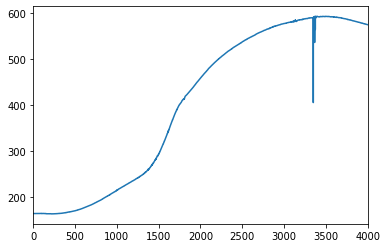

In [3]:
import matplotlib.pyplot as plt

plt.plot(data['El1.Average'])
plt.xlim(0,4000)

In [4]:
# Glitch at 3500
# limit data to 3000 using indexing - data[:3000]

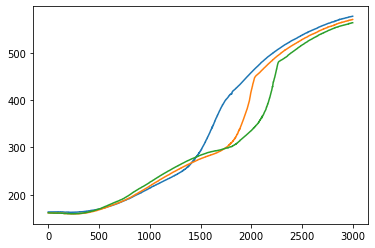

In [5]:
# Check data is good
plt.plot(data['El1.Average'][:3000])
plt.plot(data['El2.Average'][:3000])
plt.plot(data['El3.Average'][:3000])

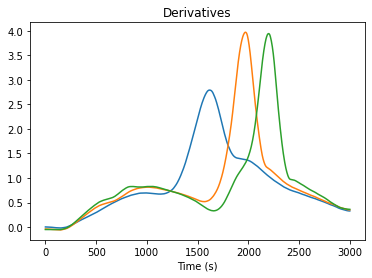

In [6]:
# Use the module from pozzocapstone/musical-robot
# Current output is a plot of the derivatives as a sanity check

import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import filtfilt
from scipy.interpolate import BSpline

infl = []
peak_indices = []

for i in range(3):

    # Interpolate the data to find the a function f that can be smoothed 
    f = interp1d(data['Relative time'][:3000],
                 data[f'El{str(i+1)}.Average'][:3000],
                 bounds_error=False)

    # Generate a linear space domain
    # numpy.linspace(start, stop, num)
    x = np.linspace(min(data['Relative time'][:3000]), max(data['Relative time'][:3000]), len(data['Relative time'][:3000]))
    y = f(x)

    # Parameters for smoothing filter
    n = 150  # the larger n is, the smoother curve will be. 150 works well for our data
    b = [1.0 / n] * n
    a = 1

    # This applies a smoothing to y (zero-phase filter)
    yy = filtfilt(b,a,y)

    # Check data looks good:
    # plt.plot(yy)

    # Combines x and filtered y
    gradient_array = np.column_stack((x,yy))
    # plt.plot(gradient_array)

    # Calculating gradient
    first_gradient = np.gradient(gradient_array,axis=0)
    # plt.plot(first_gradient)

    # Calculating derivative
    # this just applies a scaling
    derivative = first_gradient[:,1]/first_gradient[:,0]
    plt.plot(derivative)

    # Finding peaks in the derivative plot
    # Heavy smoothing (n = 100+) helps without really affecting the data 
    peaks, properties = find_peaks(derivative, height=0)

    # Get 1 peak height
    peak_heights = properties['peak_heights']
    a = list(peak_heights)
    max_height1 = np.max(a)

    # Appending the index of the highest peak to a list
    inf_index1 = list(peak_heights).index(max_height1)

    # Appending the frame number in which these peaks occur to a list
    peak_indices.append(peaks[inf_index1])

    # Appending the temperature at the peaks.
    infl.append(yy[peak_indices])

plt.title('Derivatives')
plt.xlabel('Time (s)')
plt.show()

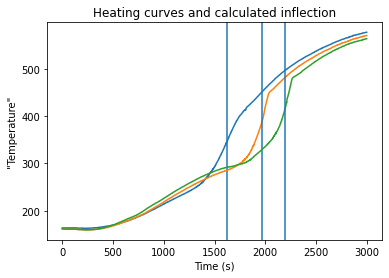

In [7]:
# Plot data with peak 
for i in range(3):
    plt.plot(data[f'El{str(i+1)}.Average'][:3000])
    plt.axvline(peak_indices[i])

plt.title('Heating curves and calculated inflection')
plt.xlabel('Time (s)')
plt.ylabel('"Temperature"')
plt.show()